In [1]:
import json
import random
import numpy as np
from matplotlib import pyplot as plt
import cs_vqe.circuit as cs_circ
import utils.plotting_tools as plot
import utils.qonversion_tools as qonvert
import utils.linalg_tools as la
import utils.bit_tools as bit
import utils.cs_vqe_tools_original as cs_tools
from qat.lang.AQASM import Program, X, H, S, CNOT, RZ
from qat.core.variables import Variable
from qat.core import Observable, Term
from qat.plugins import ScipyMinimizePlugin
from qat.qpus import Stabs, LinAlg, MPS, Feynman

/home/tweaving/.local/lib/python3.8/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')
/home/tweaving/.local/lib/python3.8/site-packages/qiskit/aqua/components/optimizers/optimizer.py:49: DeprecationWarning: The package qiskit.aqua.components.optimizers is deprecated. It was moved/refactored to qiskit.algorithms.optimizers (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua.components.optimizers',


Will store matrices in sparse form


ModuleNotFoundError: No module named 'qat'

In [2]:
with open('data/model_data.json', 'r') as json_file:
    model_data = json.load(json_file)

for mol in model_data.keys():
    print(mol, model_data[mol]['chem_acc_num_q'])
    for name, a in model_data[mol]['ansatze'].items():
        print('-', name, len(a))

H2O_STO-3G_SINGLET 7
- uccsd 228
- excite3 84
- excite4 168
- excite5 184
LiH_STO-3G_SINGLET 4
- uccsd 112
- excite3 36
- excite4 44
- excite5 56
HF_STO-3G_SINGLET 4
- uccsd 44
- excite3 8
- excite4 44
- excite5 44
CH2_STO-3G_SINGLET 8
- uccsd 220
- excite3 26
- excite4 208
- excite5 344
BeH2_STO-3G_SINGLET 7
- uccsd 176
- excite3 60
- excite4 72
- excite5 92
Be_STO-3G_SINGLET 3
- uccsd 24
- excite3 12
- excite4 12
- excite5 36
C_STO-3G_SINGLET 4
- uccsd 8
- excite3 30
- excite4 46
- excite5 46
NH_STO-3G_SINGLET 6
- uccsd 36
- excite3 16
- excite4 128
- excite5 152
BH_STO-3G_SINGLET 6
- uccsd 60
- excite3 64
- excite4 72
- excite5 72
B+_STO-3G_SINGLET 3
- uccsd 16


In [3]:
speciesname = "H2O_STO-3G_SINGLET"
mol_model    = model_data[speciesname]
anz_op = mol_model['ansatze']['excite4']

In [4]:
mol_circ = cs_circ.cs_vqe_circuit(model_data=mol_model)

num_sim_q = mol_circ.chem_acc_num_q
print('Number of terms in the ansatz:', len(anz_op))
print('%s reaches chemical accuracy for %i-qubit CS-VQE' % (speciesname, num_sim_q))
#mol_circ.plot_cs_vqe_errors()

Number of terms in the ansatz: 168
H2O_STO-3G_SINGLET reaches chemical accuracy for 7-qubit CS-VQE


In [5]:
def plot_qlm_result(result):
    nfev = len(eval(result.meta_data['optimization_trace']))
    energy=eval(result.meta_data['optimization_trace'])

    fig, ax = plt.subplots(figsize=(10,4))
    ax.plot([np.log10(abs(e-mol_circ.truegs)) for e in energy], label='CS-VQE convergence', color = "black")
    ax.hlines(np.log10(0.0016), 0, nfev, color='green', label='Chemical accuracy', ls='--')
    ax.hlines(np.log10(mol_circ.HF_energy-mol_circ.truegs), 0, nfev, color='red', label='Hartree-Fock energy', ls='--')
    ax.hlines(np.log10(mol_circ.noncon-mol_circ.truegs), 0, nfev, color='orange', label='Noncontextual ground state energy', ls='--')
    #plt.hlines(true_gs+0.0016, 0, nfev, color='pink')
    ax.set_title('{}: {}-qubit CS-VQE simulation'.format(speciesname, num_sim_q))
    ax.set_xlabel("Optimization count")
    ax.set_ylabel("Logarithmic error [log(Ha)]")
    ax.legend()
    return fig

In [6]:
class QLM_circuit():
    """Class for building and executing QLM circuits
    """
    gate_dict = {'X':X,'H':H,'S':S,'SDG':S.dag(),'RZ':RZ,'CX':CNOT}
    
    def __init__(self,
                 n_qubits,
                 qpu_type   = LinAlg(use_GPU=False),
                 opt_method = 'COBYLA',
                 maxiter    = 1000,
                 theta0     = None
                 ):
        
        optimizer=ScipyMinimizePlugin(method=opt_method,
                                    tol=1e-3,
                                    options={"maxiter": maxiter},
                                    x0=theta0)
        self.qpu = optimizer | qpu_type
        self.n_qubits = n_qubits
        
        
    def construct_hamiltonian(self, ham_dict):
        assert(len(list(ham_dict.keys())[0])==self.n_qubits)
        pauli_terms = [Term(coeff, op, list(range(self.n_qubits))) for op, coeff in ham_dict.items()]
        hamiltonian = Observable(self.n_qubits,pauli_terms=pauli_terms)
        return hamiltonian
        
        
    def build_qlm_circuit(self, instructions):
        for i in instructions[::-1]:
            if i[1]!=[]:
                num_params = i[1][0] + 1
                break

        prog = Program()
        qbits_reg = prog.qalloc(self.n_qubits)
        params = [prog.new_var(float, "\\P{}".format(i)) for i in range(num_params)]

        for gate, var_num, q_pos in instructions:
            q_pos = [self.n_qubits-p-1 for p in q_pos] #qubit ordering is reversed compared with Qiskit
            if gate == 'RZ':
                prog.apply(RZ(params[var_num[0]]), qbits_reg[q_pos[0]])
            elif gate == 'CX':
                prog.apply(CNOT, qbits_reg[q_pos[0]], qbits_reg[q_pos[1]])
            else:
                prog.apply(self.gate_dict[gate], qbits_reg[q_pos[0]])

        qc = prog.to_circ()

        return qc
    
    
    def run_vqe(self, ham_dict, instructions):
        
        hamiltonian = self.construct_hamiltonian(ham_dict)
        qc = self.build_qlm_circuit(instructions)
        job = qc.to_job(job_type="OBS", observable=hamiltonian)
        result = self.qpu.submit(job)
        
        return result

In [ ]:
ham_dict, num_sim_q, num_params, instructions = mol_circ.qlm_circuit(anz_op, num_sim_q).values()
qlm_circ = QLM_circuit(num_sim_q, opt_method='COBYLA', maxiter=5000, theta0=mol_circ.init_param)
result = qlm_circ.run_vqe(ham_dict, instructions)
error  = result.value-mol_circ.truegs; print(error)
fig = plot_qlm_result(result)

In [18]:
theta0=np.array([ 1.82542011e-02,  5.86059619e-03,  7.84996606e-03, -1.11218671e-03,
        8.25936394e-03, -1.20183855e-02, -1.57995366e-02,  5.14283275e-03,
       -2.42391937e-02,  1.68741384e-03,  8.44720656e-03,  7.80205732e-03,
        5.88355069e-03,  8.87433588e-04,  3.14620821e-03,  3.16959863e-03,
        8.54769785e-03, -5.01993702e-03, -9.04387800e-03, -7.63631164e-04,
       -1.17210775e-03,  6.02426491e-03,  3.71585537e-02, -2.73654577e-02,
        2.05603662e-04,  7.31525616e-03, -1.15314589e-02,  2.64563078e-03,
       -1.27612693e-02, -4.86472833e-04, -2.42131264e-02, -2.00821238e-03,
       -1.87104163e-03,  1.44847174e-02,  3.68854738e-03,  2.93937353e-03,
        7.71078020e-04,  5.54846585e-03,  1.19716806e-03, -3.08661559e-02,
       -4.19407595e-02, -2.53918107e-05, -1.07715285e-02,  2.15274898e-02,
       -3.96799627e-02, -6.16255636e-03,  1.77936258e-03, -2.60403055e-03,
        3.01681176e-03, -6.30344287e-03,  1.08539870e-03,  6.67109880e-03,
        1.52198712e-02, -4.80997520e-02,  1.58288849e-03,  1.73723190e-02,
        1.94308980e-02,  3.47692455e-03,  1.99616999e-03,  1.19103234e-02,
        3.50478136e-03,  6.26139838e-03, -4.02159428e-03,  3.07813025e-03,
       -2.08948139e-02,  2.22350321e-02, -1.33957309e-01,  3.68571734e-03,
        4.07331062e-03, -5.15380735e-03, -9.53410889e-03,  1.92487461e-02,
        1.30707563e-02,  1.51308873e-02,  8.10653288e-03, -1.11666039e-02,
       -4.64891138e-03, -7.71690579e-03, -1.59156924e-03,  2.90268708e-03,
       -2.20680113e-02,  2.29720807e-02, -1.75356892e-03,  2.12012289e-03,
       -4.51101063e-04, -8.94576366e-03, -3.63933149e-02,  2.35407001e-03,
        3.30661905e-03,  1.56194378e-02, -1.47247481e-02, -7.13176762e-03,
        2.61434236e-03,  3.41670936e-02, -2.98792123e-03, -3.24041343e-02,
       -2.79870998e-03,  3.70870665e-03, -8.99472190e-03, -1.17400813e-03,
        6.78930543e-03, -2.27399471e-03, -3.61618498e-03,  1.15166746e-02,
       -2.39012315e-02,  1.06311579e-02, -5.86290336e-03,  1.65156523e-02,
       -1.35581270e-03, -1.64973389e-03,  5.77428470e-03,  5.15779005e-02,
        1.60133347e-03,  1.41828149e-02, -3.31696481e-03, -2.78510675e-03,
        2.23418907e-02,  3.28570619e-02, -1.34353672e-02,  1.94866757e-03,
        1.06339692e-02,  4.46688087e-02,  5.36264512e-03, -1.38705713e-02,
       -1.01268077e-05, -1.91108864e-02,  1.30106453e-02,  3.63018691e-02,
       -4.84143634e-03, -7.37972981e-03, -5.69644622e-03, -2.03458229e-02,
       -3.27741471e-02, -7.44354556e-03, -1.15079242e-02,  1.15721763e-02,
        2.53861362e-02,  1.93654510e-02, -2.24511220e-03, -2.11297970e-03,
       -1.32067809e-02,  9.74356733e-03, -3.15025286e-03, -5.04100471e-03,
       -1.44930951e-02, -2.74816989e-04,  5.71089957e-03, -9.34491382e-03,
       -3.19169702e-02, -1.53104350e-02, -2.26575027e-02, -1.71489424e-02,
       -9.83487595e-03,  3.09897055e-03,  2.02678697e-02,  2.34173855e-02,
       -1.59192217e-02,  2.87832899e-02, -5.61193336e-03, -4.81490030e-03,
       -6.95154663e-03, -3.36184413e-03, -6.34374065e-04,  1.15658707e-02,
        1.20610343e-02, -3.15914116e-03,  4.45759708e-03,  2.25625381e-03,
       -1.46687309e-02, -5.69229184e-03,  7.99660415e-03, -1.03804886e-02,
        1.56393541e-02,  3.37929316e-02, -1.20912058e-02, -7.33574184e-03,
       -1.05140911e-02,  7.26756891e-03,  2.85205748e-02,  4.44919700e-02,
       -9.60150810e-03, -9.04090828e-03, -7.04441008e-03, -6.75504663e-03,
       -1.64289985e-02,  1.92351595e-03, -1.17017726e-03, -8.45844181e-03,
       -1.55735278e-02, -9.81100490e-04,  7.60480222e-03,  4.26922580e-02,
       -1.50721981e-02,  1.89845112e-02, -7.02985411e-03, -9.21079923e-03,
       -7.78323162e-03, -5.67951280e-03,  1.77834314e-02, -4.16971097e-03,
       -7.04818245e-03, -1.88516204e-02,  2.05904791e-02,  3.32218758e-02,
       -9.79248557e-03, -3.93590718e-03])

In [8]:
fig.savefig('plots/'+speciesname+'_CS-VQE_test.png', dpi=300, bbox_inches='tight')

data={}
for k in result.meta_data.keys():
    data[str(k)] = result.meta_data[k]
    
with open("data/QLM_circuits/"+speciesname+"_CS-VQE_test.json", "w") as outfile: 
    json.dump(data, outfile)

In [ ]:
print('Noncon error:', mol_circ.noncon-mol_circ.truegs, '\n')
qlm_circ = QLM_circuit(num_sim_q, opt_method='COBYLA', maxiter=5000)
chemacc=0.0016
current_error=1
final_ops = []
while current_error > chemacc:
    pauli_errors = []
    lost = []
    for pauli in uccsd.keys():
        if pauli not in final_ops:
            anz_ops = final_ops + [pauli] #random.choices(list(uccsd.keys()), k=30)
            #print('Ansatz operators:', anz_ops)
            anz = {op:uccsd[op] for op in anz_ops}
            ham_dict, num_sim_q, num_params, instructions = mol_circ.qlm_circuit(anz, num_sim_q).values()
            try:
                result = qlm_circ.run_vqe(ham_dict, instructions)
                error  = result.value-mol_circ.truegs
                pauli_errors.append((pauli, error))
                #print("Minimum energy =", result.value, '| error =', error, '| Chemical accuracy?', error<0.0016)
                #print("Optimal angles =", result.meta_data["parameters"], '\n')

                if error<0.0016:
                    #final_ops.append(pauli)
                    plot_qlm_result(result)
                    break
            except:
                print('<!> QLM error \n')
                lost.append(pauli)

    pauli_out, current_error = sorted(pauli_errors, key=lambda x:x[1])[0]
    final_ops.append(pauli_out)
    
    print('Ansatz terms:', final_ops, '| error =', current_error, '\n')
    if lost!=[]:
        print('QLM error on terms:', lost)
    
print(final_ops)

Noncon error: 0.07075434472042019 

<!> QLM error 

<!> QLM error 

<!> QLM error 

<!> QLM error 

<!> QLM error 

<!> QLM error 

<!> QLM error 

<!> QLM error 

<!> QLM error 

<!> QLM error 

<!> QLM error 

<!> QLM error 

<!> QLM error 

<!> QLM error 

<!> QLM error 

Ansatz terms: ['IXXIZZYI'] | error = 0.06920550440547402 

QLM error on terms: ['IIZZIIII', 'IIXXIIII', 'IIYYIIII', 'IYXIZZXI', 'IYYZZZXI', 'IYYIZZYI', 'IYXZZZYI', 'YZIXZZZX', 'XZZXZZZX', 'XZIYZZZX', 'YZZYZZZX', 'XZIXZZZY', 'YZZXZZZY', 'YZIYZZZY', 'XZZYZZZY']
Ansatz terms: ['IXXIZZYI', 'YZIXZZZX'] | error = 0.0676568218543494 

Ansatz terms: ['IXXIZZYI', 'YZIXZZZX', 'IXYIZZXI'] | error = 0.06765144588336369 

<!> QLM error 

Ansatz terms: ['IXXIZZYI', 'YZIXZZZX', 'IXYIZZXI', 'IIIIIIII'] | error = 0.06765111981763994 

QLM error on terms: ['ZZZXZZZZ']
Ansatz terms: ['IXXIZZYI', 'YZIXZZZX', 'IXYIZZXI', 'IIIIIIII', 'IYXZZZYI'] | error = 0.06765237690150627 



In [ ]:
#fig.savefig('plots/'+speciesname+'_CS-VQE_test.png', dpi=300, bbox_inches='tight')

In [ ]:
#data={}
#for k in result.meta_data.keys():
#    data[str(k)] = result.meta_data[k]
#    
#with open("data/QLM_circuits/"+speciesname+"_CS-VQE_test.json", "w") as outfile: 
#    json.dump(data, outfile)

In [3]:
plot_mols = ['Be_STO-3G_SINGLET',
             'B+_STO-3G_SINGLET',
             'LiH_STO-3G_SINGLET', 
             'HF_STO-3G_SINGLET', 
             'BeH2_STO-3G_SINGLET']

Be_STO-3G_SINGLET
B+_STO-3G_SINGLET
LiH_STO-3G_SINGLET
HF_STO-3G_SINGLET
BeH2_STO-3G_SINGLET


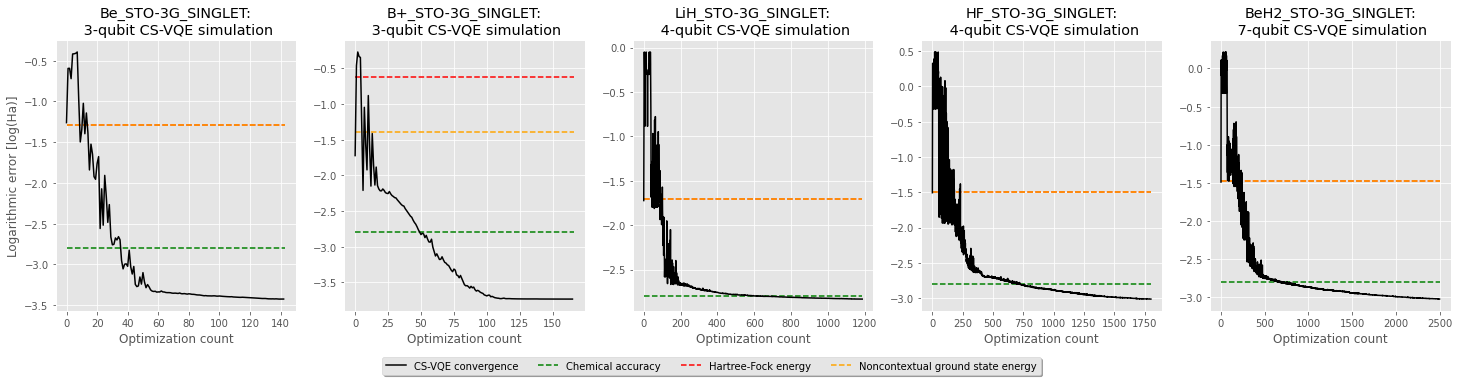

In [6]:
fig, axes = plt.subplots(ncols=5, nrows=1, figsize=(25,5))

for index, speciesname in enumerate(plot_mols):
    print(speciesname)
    with open('data/QLM_circuits/'+speciesname+'_CS-VQE_test.json', 'r') as json_file:
        data = json.load(json_file)
        
    nfev = len(eval(data['optimization_trace']))
    energy=eval(data['optimization_trace'])
    
    l1=axes[index].plot([np.log10(abs(e-model_data[speciesname]['truegs'])) for e in energy], label='CS-VQE convergence', color = "black")
    l2=axes[index].hlines(np.log10(0.0016), 0, nfev, color='green', label='Chemical accuracy', ls='--')
    l3=axes[index].hlines(np.log10(model_data[speciesname]['hf_energy']-model_data[speciesname]['truegs']), 0, nfev, color='red', label='Hartree-Fock energy', ls='--')
    l4=axes[index].hlines(np.log10(model_data[speciesname]['noncon']-model_data[speciesname]['truegs']), 0, nfev, color='orange', label='Noncontextual ground state energy', ls='--')

    axes[index].set_title('{}:\n {}-qubit CS-VQE simulation'.format(speciesname, model_data[speciesname]['chem_acc_num_q']))
    axes[index].set_xlabel("Optimization count")
    
axes[0].set_ylabel("Logarithmic error [log(Ha)]")
axes[3].legend(loc="right",   # Position of legend
                borderaxespad=0.1,    # Small spacing around legend box
                bbox_to_anchor=(0.5, -0.2),
                ncol=4,
                fancybox=True, 
                shadow=True)

In [7]:
fig.savefig('plots/QLM_tests.png', dpi=300, bbox_inches='tight')